<a href="https://colab.research.google.com/github/sareenv/SOEN-6611-Project/blob/main/Measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Required Libraries

In [142]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import requests
from IPython.display import display # to dispay the contents of the data frames.


from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/MEASUREMENT-PROJECT/DATA")



# splits the data into the three seperate files.
df_restuarant = pd.read_csv('test.csv')
split_one = df_restuarant.iloc[:2198, :]
split_two = df_restuarant.iloc[2199: 4396, :]
split_three = df_restuarant.iloc[4396: , :]
# split_one.reset_index()
# split_two.reset_index()
# split_three.reset_index()

split_one.to_csv("./file_one.csv")
split_two.to_csv("./file_two.csv")
split_three.to_csv("./file_three.csv")


# -----------------------------------------------
# Adding the record's age since, 
# there exists no age attribute in the datasets  
# provided to our team.
# -----------------------------------------------

split_one['recordAge'] = np.random.randint(1, 60, split_one.shape[0])
split_two['recordAge'] = np.random.randint(1, 60, split_two.shape[0])
split_three['recordAge'] = np.random.randint(1, 60, split_three.shape[0])

split_one.to_csv("./file_one.csv")
split_two.to_csv("./file_two.csv")
split_three.to_csv("./file_three.csv")


# read the three splitted part of the dataframe. 
df_timeone = pd.read_csv('./file_one.csv')
df_timetwo = pd.read_csv('./file_two.csv')
df_timethree = pd.read_csv('./file_three.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [214]:
def calculate_compliance(df):
  null_count = df[df.isna().any(axis=1) == False]
  complient_count = df[df.Currency == 'EUR']
  # print("compliant records are {}".format(complient_count.shape[0]))
  merged_df = pd.merge(null_count, complient_count,how="outer")
  # print("nrec_com is {}".format(merged_df.shape[0]))
  return merged_df.shape[0]/df.shape[0]

  
def validity_calculation(compliant_records):
  # credibility and compliance. 
  weight_credibility = 0.5
  weight_compliance = 0.5
  credibility = 1
  compliance = compliant_records
  validitity = compliance * weight_compliance + weight_credibility * credibility
  return validitity

# returns the count of the records which lies 
# in the some sort of acceptable range.
def getRecordsCntWithinRange(df, low, high):
  ranged_records = df[df['recordAge'] >= low] 
  ranged_records = df[df['recordAge'] <= high]
  return ranged_records.shape[0]

def get_duplicates(df,exclude):
  new_df = df
  new_df = new_df.drop(exclude, axis=1)
  new_df = new_df.loc[:,~new_df.columns.str.match("Unnamed")]
  # print(new_df)
  pj = new_df.duplicated().sum()
  return pj

def varicity_calculation(df, lbd, pj):
  # availability. 
  total_number_request = 1000
  sucess_request = 1000
  availablity = sucess_request / total_number_request # since the availablity of the system is computed based on the no of succ_Req / total Req.

  # currentness
  low_range_value = 16 # low_range based on the box plot. 
  high_range_value = 45 # high_range based on the box plot.
  acceptable_cnt = getRecordsCntWithinRange(df, low_range_value, high_range_value)
  currentness = acceptable_cnt / lbd

  # print("Currentness is {}".format(currentness))

  # accuracy. 

  # NOTE: Nadip please verify if there exist any duplicate values.
  pj = get_duplicates(df, ['recordAge'])
  if(pj == 0):
    summed_value = 0
  else:
    summed_value = math.log2(pj) * pj
  h_acc = math.log2(lbd) - (1/lbd * summed_value) # entropy of the multi-datasets.
  h_max = math.log2(lbd)
  accuracy = h_acc / h_max
  # print(accuracy)
   
  # completeness.
  non_null_records = df[df.isna().any(axis=1) == False] # non-null values. 
  completeness = non_null_records.shape[0] / lbd
  # print("Completeness is {}".format(completeness))

  # veracity calculation.
  weight_completeness = 0.25
  weight_accuracy = 0.25
  weight_availability = 0.25
  weight_currentness = 0.25
  varicity = weight_accuracy * accuracy + weight_completeness * completeness + weight_currentness * currentness + weight_availability * availablity
  return varicity


# tracibility_values = [(200, 300)]
def vincularity_calculation(tracibility_values, nds_count):
  tracibility_sum = 0
  for trace_val in tracibility_values:
    trace_records = trace_val[0]
    ldst = trace_val[1]
    tracibility_sum += trace_records / ldst
  return tracibility_sum / nds_count

# data-extraction phase.
compliance_one = calculate_compliance(df_timeone)
validitiy_one = validity_calculation(compliance_one)

temp_ds = pd.merge(df_timetwo, df_timeone,how="outer")
compliance_two = calculate_compliance(temp_ds)
validity_two = validity_calculation(compliance_two)

temp_ds = pd.merge(temp_ds, df_timethree,how="outer")
compliance_three = calculate_compliance(temp_ds)
validity_three = validity_calculation(compliance_three)


print("Validity values are {}, {}, {}".format(validitiy_one, validity_two, validity_three))

def get_tracability(ldst, tracable_records):
  traceable_records = tracable_records / ldst
  return traceable_records



def traceable_records(df):
  null_count = df[df.isna().any(axis=1) == False]
  complient_count = df[df.Currency == 'EUR']
  merged_df = pd.merge(null_count, complient_count,how="outer")
  return merged_df

# --------------------------
#| Vincularity Calculation. |
# --------------------------


ldst_one = df_timeone.shape[0]
ldst_two = df_timetwo.shape[0] + df_timeone.shape[0]
ldst_three = df_timethree.shape[0] + df_timetwo.shape[0] + df_timeone.shape[0]
nds_cnt = 3
lbd = ldst_three

print("ldst are is {}, {}, {}".format(ldst_one, ldst_two, ldst_three))
print("lbd is {}".format(lbd))

traceable_records_one = traceable_records(df_timeone).shape[0]
temp_ds = pd.merge(df_timetwo, df_timeone,how="outer")
traceable_records_two = traceable_records(temp_ds).shape[0]
temp_ds = pd.merge(temp_ds, df_timethree,how="outer")
traceble_records_three = traceable_records(temp_ds).shape[0]

print("Tracable records are {}, {}, {}".format(traceable_records_one, traceable_records_two, traceble_records_three))

tracability_one = get_tracability(ldst_one, traceable_records_one)
tracability_two = get_tracability(ldst_two, traceable_records_two)
tracabolity_three = get_tracability(ldst_three, traceble_records_three)

vincularities = [tracability_one, tracability_two, tracabolity_three]
print("vincularities are {}".format(vincularities))

# --------------------------------------------------------------------------
# Veracity Section - get the records cnt which lies in the acceptable range.|
# --------------------------------------------------------------------------

# record_cnt_one_acceptable_range = getRecordsCntWithinRange(df_timeone, 16, 45)
# record_cnt_two_acceptable_range = getRecordsCntWithinRange(df_timetwo, 16, 45)
# record_cnt_three_acceptable_range = getRecordsCntWithinRange(df_timethree, 15, 45)

# print("Acceptable record count is {}, {}, {}".format(record_cnt_one_acceptable_range, 
#                                                      record_cnt_two_acceptable_range, 
#                                                      record_cnt_three_acceptable_range))


varicity_one = varicity_calculation(df_timeone, lbd, 0)
temp_ds_two = pd.merge(df_timetwo, df_timeone,how="outer")
varicity_two = varicity_calculation(temp_ds_two, lbd, 0)
temp_ds_three = pd.merge(temp_ds, df_timethree,how="outer")
varicity_three = varicity_calculation(temp_ds_three, lbd, 0)

print("Veracities are {}, {}, {}".format(varicity_one, varicity_two, varicity_three))

# -----------------------------
# After the pre-procesing phase|
# -----------------------------


non_null_count = temp_ds_three[temp_ds_three.isna().any(axis=1) == False]



print("non null records are {} at t3".format(non_null_count.shape[0]))


# -----------------------------
# The procesing phase.         |
# -----------------------------


# remove the unnecessary column. 

# remove the phone numberm Url and  WebsiteUrl column.
temp_ds_three = temp_ds_three.drop(["PhoneNumber"], axis=1)
temp_ds_three = temp_ds_three.drop(["Url"], axis=1)
temp_ds_three = temp_ds_three.drop(["WebsiteUrl"], axis=1)

print("before removing the duplicates the cnt is {}".format(temp_ds_three.shape[0]))

# remove the duplicate data.
temp_ds_three = temp_ds_three.loc[:,~temp_ds_three.columns.str.match("Unnamed")]
temp_ds_three = temp_ds_three.drop_duplicates(keep='last')

# split_one
split_one = temp_ds_three[temp_ds_three['recordAge'].between(0, 20)]
split_two = temp_ds_three[temp_ds_three['recordAge'].between(21, 40)]
split_three = temp_ds_three[temp_ds_three['recordAge'].between(41, 60)]

nrec_comp_one = calculate_compliance(split_one)
nrec_comp_two = calculate_compliance(split_two)
nrec_comp_three = calculate_compliance(split_three)
validity_one = validity_calculation(compliant_records= nrec_comp_one)
validity_two = validity_calculation(compliant_records= nrec_comp_two)
validity_three = validity_calculation(compliant_records= nrec_comp_three)

print("validity values after the pre-processing are {}, {}, {}".format(validity_one, validity_two, validity_three))

# traceable_records(split_one).shape[0]


traceable_records_one = traceable_records(split_one).shape[0]
traceable_records_two = traceable_records(split_two).shape[0]
traceable_records_three = traceable_records(split_three).shape[0]

ldst_one = split_one.shape[0]
ldst_two = split_two.shape[0] + split_one.shape[0]
ldst_three = split_two.shape[0] + split_one.shape[0] + split_three.shape[0]
vincularity_one = get_tracability(ldst_one, traceable_records_one) / 1
vincularity_two = get_tracability(ldst_two, traceable_records_one + traceable_records_two) / 1
vincularity_three = get_tracability(ldst_three, traceable_records_one + traceable_records_two + traceable_records_three) / 1

print("vincularities are {}, {}, {}".format(vincularity_one, vincularity_two, vincularity_three))

# veracity after the 
lbd = split_one.shape[0] + split_two.shape[0] + split_three.shape[0]
print("Lbd value at the pre-processing {}".format(lbd))
viracity_one = varicity_calculation(split_one, lbd, 0)
temp_ds_two = pd.merge(split_one, split_two,how="outer")
viracity_two = varicity_calculation(temp_ds_two, lbd, 0)
temp_ds_three = pd.merge(temp_ds_two, split_three,how="outer")
viracity_three = varicity_calculation(temp_ds_three, lbd, 0)
print("Veracities are {}, {}, {}".format(varicity_one, varicity_two, varicity_three))



# -----------------
# Processing phase |
# -----------------


# replace the null values with average.
split_one.drop(split_one[split_one['MinPrice'].isna()].index, inplace=True)
split_two.drop(split_two[split_two['MinPrice'].isna()].index, inplace=True)
split_three.drop(split_three[split_three['MinPrice'].isna()].index, inplace=True)


def calculateMeanPrice(values):
  sum = 0
  for val in values:       
    try:
      repl = float(val.replace(',', ''))
      sum += repl
    except Exception as ex:
      continue
    

  mean = sum / len(values)
  return mean


# converting the currency values into the euros
currencies = { "EUR" : 1, "USD" : 0.98, "GBP" : 1.19, 
    "CNY" : 0.15, "MOP" : 0.12, "HKD" : 0.12, 
    "JPY" : 0.0073, "KRW" : 0.00075, "SEK" : 0.096, 
    "NOK" : 0.10, "DKK" : 0.13, "SGD" : 0.71, 
    "TWD" : 0.033, "CHF" : 1.02, "AED" : 0.27, 
    "THB" : 0.027, "BRL" : 0.19, "HRK" : 0.13, 
    "HUF": 0.0025, "CZK": 0.041
    }

def convertCurrency(split_one):
  for row in split_one.itertuples():
    try:
      currency = split_one.at[row.Index, "Currency"]
      original_min_val = split_one.at[row.Index, "MinPrice"]
      if currency == None:
        continue
      exchange = currencies[currency]
      converted_value = float(original_min_val.replace(",", "")) * exchange
      split_one.loc[row.Index, "MinPrice"] = converted_value
      split_one.loc[row.Index, "Currency"] = "EUR"
    except Exception as ex:
      continue

# convert's the currency from any another one to the 
convertCurrency(split_one)
convertCurrency(split_two)
convertCurrency(split_three)


# ----------------------------- 
#   3V'S after the processing
# ------------------------------




Validity values are 1.0, 0.9740335351653471, 0.923419960018453
ldst are is 2097, 4294, 6503
lbd is 6503
Tracable records are 2097, 4071, 5507
vincularities are [1.0, 0.948067070330694, 0.846839920036906]
Veracities are 0.6424727049054282, 0.7798708288482239, 0.8956338401837461
non null records are 5376 at t3
before removing the duplicates the cnt is 6503
validity values after the pre-processing are 0.9997673336435551, 1.0, 0.9993003731343284
vincularities are 0.9995346672871103, 0.999770484278173, 0.9993847100446085
Lbd value at the pre-processing 6501
Veracities are 0.6424727049054282, 0.7798708288482239, 0.8956338401837461


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [218]:
from re import split
# validity after the processing phase.
compliance_one = calculate_compliance(split_one)
validitiy_one = validity_calculation(compliance_one)

temp_ds = pd.merge(split_one, split_two,how="outer")
compliance_two = calculate_compliance(temp_ds)
validity_two = validity_calculation(compliance_two)

temp_ds = pd.merge(temp_ds, split_three,how="outer")
compliance_three = calculate_compliance(temp_ds)
validity_three = validity_calculation(compliance_three)
print("Validity values after processing are {}, {}, {}".format(validitiy_one, validity_two, validity_three))

# vincularity 
ldst_one = split_one.shape[0]
ldst_two = split_one.shape[0] + split_two.shape[0]
ldst_three = split_one.shape[0] + split_two.shape[0] + split_three.shape[0]
lbd = ldst_three

traceable_records_one = traceable_records(split_one).shape[0]
temp_ds = pd.merge(split_one, split_two,how="outer")
traceable_records_two = traceable_records(temp_ds).shape[0]
temp_ds = pd.merge(temp_ds, split_three,how="outer")
traceble_records_three = traceable_records(temp_ds).shape[0]

print("Tracable records are {}, {}, {}".format(traceable_records_one, traceable_records_two, traceble_records_three))

tracability_one = get_tracability(ldst_one, traceable_records_one)
tracability_two = get_tracability(ldst_two, traceable_records_two)
tracabolity_three = get_tracability(ldst_three, traceble_records_three)

vincularities = [tracability_one, tracability_two, tracabolity_three]
print("vincularities are {}".format(vincularities))

# veracity

varicity_one = varicity_calculation(split_one, lbd, 0)
temp_ds_two = pd.merge(split_one, split_two,how="outer")
varicity_two = varicity_calculation(temp_ds_two, lbd, 0)
temp_ds_three = pd.merge(temp_ds_two, split_three,how="outer")
varicity_three = varicity_calculation(temp_ds_three, lbd, 0)

print("Veracities are {}, {}, {}".format(varicity_one, varicity_two, varicity_three))

Validity values after processing are 1.0, 1.0, 1.0
Tracable records are 2148, 4356, 6497
vincularities are [1.0, 1.0, 1.0]
Veracities are 0.6652473615211796, 0.8347844158733916, 0.9391047706174696


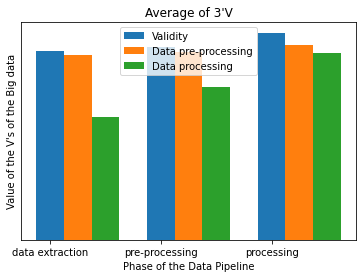

In [254]:
from matplotlib.axis import YAxis
def processData(before_veracity, scale_factor, after_pre_processing_scale_factor, title="veracity"):
  data_set = ["data extraction", "pre-processing", "processing"]
  X_axis = np.arange(len(data_set))
  after_veracity = []
  after_pre_processing = []

  for val_idx in range(0, len(before_veracity)):
    n_val = before_veracity[val_idx] * scale_factor[val_idx]
    after_veracity.append(n_val)


  for val_idx in range(0, len(before_veracity)):
    n_val = before_veracity[val_idx] * after_pre_processing_scale_factor[val_idx]
    after_pre_processing.append(n_val)

  width = 0.25

  plt.bar(X_axis, before_veracity, width, label = "Validity")
  plt.bar(X_axis + width, after_veracity, width, label = "Data pre-processing")
  plt.bar(X_axis + width * 2, after_pre_processing, width, label = "Data processing")
  # YAxis.set_visible()
  # plt.set_yticks([])
  plt.xticks(X_axis, data_set)
  plt.xlabel("Phase of the Data Pipeline")
  plt.ylabel("Value of the V's of the Big data")
  plt.title("Average of 3'V")
  plt.yticks([])
  plt.legend()
  plt.plot()

processData([0.82, 0.84, 0.9], [0.98, 0.97, 0.94], [0.65, 0.79, 0.90], "compliant records")